# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторических данных: технические характеристики, комплектации и цены автомобилей нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, cv, Pool, train

In [2]:
def data_read(file):
    """
        Функция принемает путь к файлу, выводить на экран 10 сторк таблицы,
        информацию о столбцах, число дубликатов и возврашет таблицу типа DataFrame
    """
    data = pd.read_csv(file, parse_dates=[0,12, 15])
    display(data.head(10))
    display(data.describe())
    data.info(memory_usage='deep')
    print("\n"+'Количество дубликатов:', data.duplicated().sum())
    print("\n"+'Колическтво пустых значений')
    df_null = data.isnull().sum()
    print(df_null[df_null>0].sort_values(ascending=False))
    print("\n"+'Процент пустых значений')
    df_null_p = df_null/len(data)*100
    print(df_null_p[df_null_p>0].sort_values(ascending=False))
    return data

In [3]:
df = data_read('/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 148.1 MB

Количество дубликатов: 4

Колическтво пустых значений
NotRepaired    71154
VehicleType    37490
F

 Ошибки, выявленные в наборе данных:
1. Типы данных не оптимизированы;
2. Небольшое число  дубликатов;
3. Пропуски данных в столбцах NotRepaired, VehicleType, FuelType, Gearbox, Model;
4. Столбцы DateCrawled и DateCreated одинаковые;
5. Столбцы NumberOfPictures, RegistrationMonth, PostalCode, LastSeen, DateCreated, DateCrawled являются лишними для построения модели;
6. В столбцах Price, RegistrationYear, Power наблюдаются выбросы данных.

Удалим ненужные столбцы данных

In [4]:
df = df.drop(['DateCreated', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df = df.drop_duplicates().reset_index(drop=True)

Заполним пустые значения в столбцах NotRepaired, VehicleType, FuelType, Gearbox и Model

In [5]:
#Пропуски в столбцах NotRepaired, Model заполним значением unknown
for i in ['NotRepaired','Model']:
    df[i] = df[i].fillna('unknown')

#Пропуски в столбцах VehicleType, FuelType, Gearbox заполним самым популярным значением соотвествующей графе Model
for i in ['VehicleType', 'FuelType', 'Gearbox']:
    df[i] = df[i].fillna(df.groupby('Model')[i].transform(lambda x: x.value_counts().idxmax()))                        

Оптимизируем типы данных

In [6]:
converted_int = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[converted_int.columns] = converted_int

category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for i in category:
    df[i] = df[i].astype('category')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309329 entries, 0 to 309328
Data columns (total 10 columns):
Price               309329 non-null uint16
VehicleType         309329 non-null category
RegistrationYear    309329 non-null uint16
Gearbox             309329 non-null category
Power               309329 non-null uint16
Model               309329 non-null category
Kilometer           309329 non-null uint32
FuelType            309329 non-null category
Brand               309329 non-null category
NotRepaired         309329 non-null category
dtypes: category(6), uint16(3), uint32(1)
memory usage: 5.0 MB


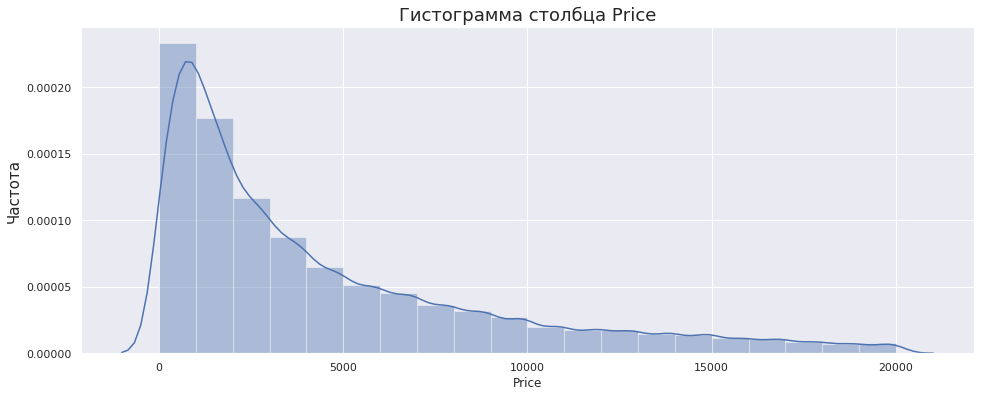

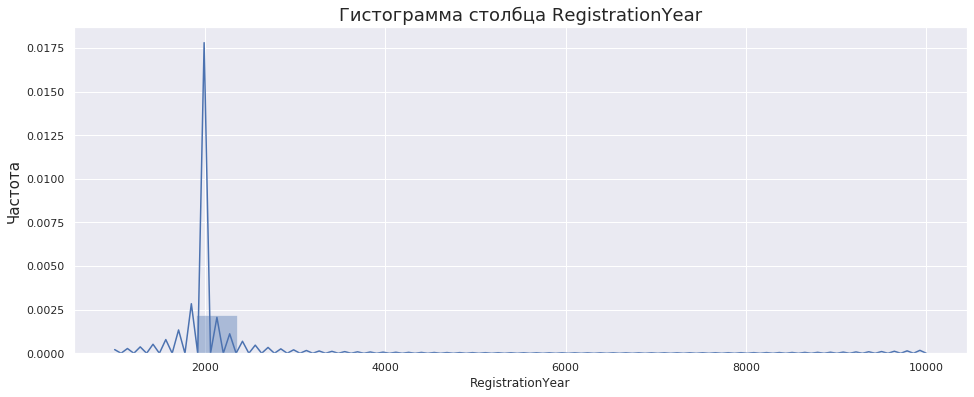

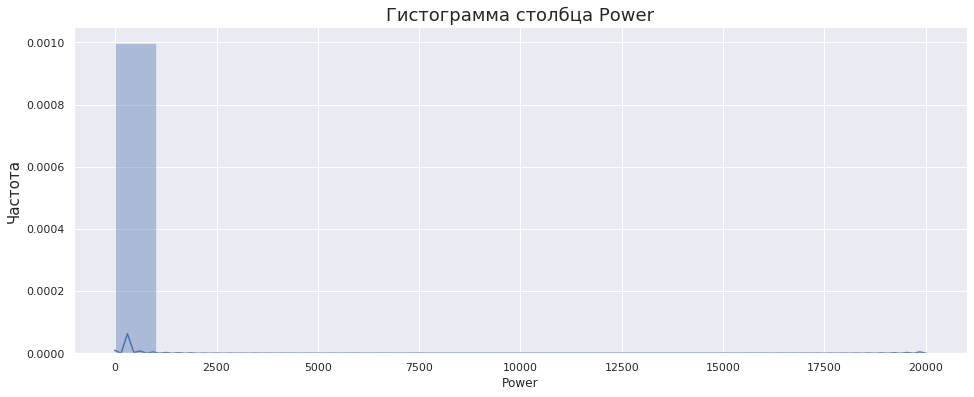

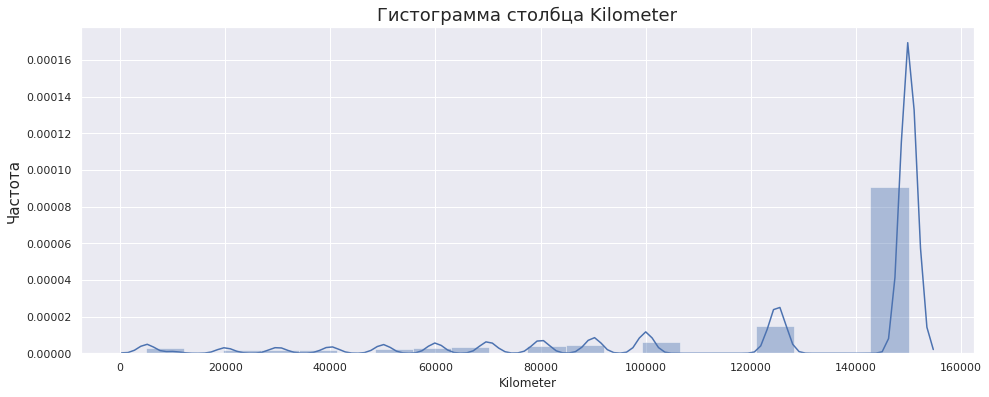

In [7]:
def show_hists(data, data_label):
    """
    Функция на вход принемает датафрейм и названия столбцов датафрейма.
    Выводом функции является цикл гистограмм каждого столбца датафрейма.
    """
    sns.set()
    plt.figure(figsize=(16, 6))
    plt.title('Гистограмма столбца ' + data_label, fontsize=18)
    plt.ylabel('Частота', fontsize=15)
    sns.distplot(data, bins=20)
    plt.show()

numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
for column in numerical_features:
    show_hists(df[column], column)

По гистограммам выше можно сделать следующие выводы:
* В столбце Price есть большое число нулевых значений;
* В столбце RegistrationYear есть большой хвост выбивающиеся по смыслу значений года регистрации автомобиля;
* В столбце Power также есть значения не соответствующих по смыслу.

Выявим число выбросов в столбцах Price, RegistrationYear, Power

In [8]:
print('Количество автомобилей с нулевой ценой: {} ({:.2f}%)'.format(len(df.loc[df['Price'] == 0])
                                                                ,100*len(df.loc[df['Price'] == 0])/len(df)) )
print('Количество автомобилей с годом регистрации > 2021 года: {} ({:.2f}%)'.format(len(df.query('RegistrationYear > 2021'))
                                                                ,100*len(df.query('RegistrationYear > 2021'))/len(df)) )
print('Количество автомобилей с годом регистрации < 1900 года: {} ({:.2f}%)'.format(len(df.query('RegistrationYear < 1900'))
                                                                ,100*len(df.query('RegistrationYear < 1900'))/len(df)) )
print('Количество автомобилей с мощностью > 1000 л.с.: {} ({:.2f}%)'.format(len(df.query('Power > 1000'))
                                                                ,100*len(df.query('Power > 1000'))/len(df)) )
print('Количество автомобилей с нулевой мощностью: {} ({:.2f}%)'.format(len(df.query('Power == 0'))
                                                                ,100*len(df.query('Power == 0'))/len(df)) )


Количество автомобилей с нулевой ценой: 8904 (2.88%)
Количество автомобилей с годом регистрации > 2021 года: 99 (0.03%)
Количество автомобилей с годом регистрации < 1900 года: 63 (0.02%)
Количество автомобилей с мощностью > 1000 л.с.: 296 (0.10%)
Количество автомобилей с нулевой мощностью: 35978 (11.63%)


In [9]:
df = df.loc[df['Price'] != 0]
df = df.query('RegistrationYear < 2021 and RegistrationYear > 1900')
df = df.query('Power < 1000 and Power > 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267138 entries, 1 to 309328
Data columns (total 10 columns):
Price               267138 non-null uint16
VehicleType         267138 non-null category
RegistrationYear    267138 non-null uint16
Gearbox             267138 non-null category
Power               267138 non-null uint16
Model               267138 non-null category
Kilometer           267138 non-null uint32
FuelType            267138 non-null category
Brand               267138 non-null category
NotRepaired         267138 non-null category
dtypes: category(6), uint16(3), uint32(1)
memory usage: 6.4 MB


Удолим данные выбросы

**Вывод:**

В ходе выполнения первого пункта сделаны следующие действия:
* оптимизированы типы данных
* удалены дубликаты;
* Заполнены пропуски данных в столбцах NotRepaired, VehicleType, FuelType, Gearbox, Model;
* Столбцы DateCrawled, NumberOfPictures, RegistrationMonth, PostalCode, LastSeen удалены, т.к. являются лишними для построения модели;
* Выявлены и удалены выбросы значений в столбцах Price, RegistrationYear, Power.

## Обучение моделей

Для обуения используем модели LinearRegression, LightGBM и  CatBoost

Подготовим данные для обучения

In [10]:
target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features
                                                                            , target, test_size=0.2, random_state=42)
print('Размер признаков обучающей выборки:', features_train.shape)
print('Размер признаков тестовой выборки:', features_test.shape)
print('Размер целевого признака обучающей выборки:', target_train.shape)
print('Размер целевого признака тестовой выборки:', target_test.shape)

Размер признаков обучающей выборки: (213710, 9)
Размер признаков тестовой выборки: (53428, 9)
Размер целевого признака обучающей выборки: (213710,)
Размер целевого признака тестовой выборки: (53428,)


In [11]:
numerical_features = ['Kilometer', 'Power', 'RegistrationYear']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

ohe_encoder = OneHotEncoder(dtype=np.bool, sparse=False, handle_unknown='ignore')
features_train_ohe = ohe_encoder.fit_transform(features_train[categorical_features])
features_test_ohe = ohe_encoder.transform(features_test[categorical_features])
print('Размер признаков обучающей выборки:', features_train_ohe.shape)
print('Размер признаков тестовой выборки:', features_test_ohe.shape)

Размер признаков обучающей выборки: (213710, 310)
Размер признаков тестовой выборки: (53428, 310)


In [12]:
ordinal_encoder = OrdinalEncoder(dtype=np.int16)
ordinal_encoder.fit(features[categorical_features])
features_train_ord = ordinal_encoder.transform(features_train[categorical_features])
features_test_ord = ordinal_encoder.transform(features_test[categorical_features])
features_train_ord.shape, features_test_ord.shape

((213710, 6), (53428, 6))

In [13]:
scaler = StandardScaler()
features_train_scal = scaler.fit_transform(features_train[numerical_features])
features_test_scal = scaler.transform(features_test[numerical_features])
print('Размер признаков обучающей выборки:', features_train_scal.shape)
print('Размер признаков тестовой выборки:', features_test_scal.shape) 

Размер признаков обучающей выборки: (213710, 3)
Размер признаков тестовой выборки: (53428, 3)


**Модель LinearRegression**

In [14]:
features_train_scal_ohe = np.concatenate((features_train_ohe, features_train_scal), axis=-1)
features_test_scal_ohe = np.concatenate((features_test_ohe, features_test_scal), axis=-1)

In [15]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train_scal_ohe, target_train)

CPU times: user 15.5 s, sys: 7.75 s, total: 23.3 s
Wall time: 23.3 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
%%time
predict = linear_model.predict(features_train_scal_ohe)

CPU times: user 160 ms, sys: 28 ms, total: 188 ms
Wall time: 187 ms


In [17]:
rmse_lr_train = mse(target_train, predict)**0.5
print('RMSE обучающей выборки: {:.2f}'.format(rmse_lr_train))

RMSE обучающей выборки: 2754.39


In [18]:
%%time
predict = linear_model.predict(features_test_scal_ohe)

CPU times: user 40.7 ms, sys: 0 ns, total: 40.7 ms
Wall time: 14.5 ms


In [19]:
rmse_lr_test = mse(target_test, predict)**0.5
print('RMSE тестовой выборки: {:.2f}'.format(rmse_lr_test)) 

RMSE тестовой выборки: 2749.01


**Модель CatBoost**

In [20]:
train_pool = Pool(data=features_train, label=target_train, cat_features=categorical_features)
params = {"iterations": 150,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 42,
          "bootstrap_type": None,
          "min_data_in_leaf": 1,
          "boosting_type": 'Plain',
          "verbose": False}
bootstrap_type = ['MVS', 'Bernoulli']
max_depth = [2, 3, 4]

In [21]:
best_score = 10000
for trap_type in bootstrap_type:
    params['bootstrap_type'] = trap_type
    for m_depth in max_depth:
        params['max_depth'] = m_depth
        score = cv(pool=train_pool, params=params, fold_count=2, plot=False).iloc[-1]['test-RMSE-mean']
        if score < best_score:
            best_score = score
            best_param = (trap_type, m_depth)

In [22]:
rmse_cb_train = best_score
print('Лучший RMSE:', rmse_cb_train)

Лучший RMSE: 1776.8731776978962


In [23]:
%%time
boots_type = best_param[0]
max_depth = best_param[1]
catboost_model = CatBoostRegressor(iterations=150, learning_rate=1, max_depth=max_depth, bootstrap_type=boots_type,
                       random_state=42, boosting_type='Plain', verbose=10)
catboost_model.fit(train_pool);

0:	learn: 3023.7279639	total: 81.9ms	remaining: 12.2s
10:	learn: 2075.2676511	total: 1.77s	remaining: 22.4s
20:	learn: 1957.2874000	total: 3.36s	remaining: 20.7s
30:	learn: 1890.5952779	total: 5.05s	remaining: 19.4s
40:	learn: 1849.9583138	total: 6.56s	remaining: 17.4s
50:	learn: 1824.4678084	total: 8.16s	remaining: 15.8s
60:	learn: 1804.7831119	total: 9.75s	remaining: 14.2s
70:	learn: 1788.7453864	total: 11.3s	remaining: 12.6s
80:	learn: 1774.3262175	total: 12.8s	remaining: 10.9s
90:	learn: 1762.1384334	total: 14.5s	remaining: 9.43s
100:	learn: 1754.1846250	total: 16s	remaining: 7.78s
110:	learn: 1744.0798364	total: 17.5s	remaining: 6.16s
120:	learn: 1735.8664062	total: 19.1s	remaining: 4.58s
130:	learn: 1726.6555540	total: 20.7s	remaining: 3s
140:	learn: 1721.9087898	total: 22.2s	remaining: 1.42s
149:	learn: 1715.2558951	total: 23.6s	remaining: 0us
CPU times: user 20.6 s, sys: 3.35 s, total: 23.9 s
Wall time: 24.8 s


Важность признаков модели CatBoost

In [24]:
fi_cb = pd.DataFrame({'Признаки':features_test.columns,'Важность':catboost_model.feature_importances_})
fi_cb = fi_cb.sort_values('Важность',ascending=False)
fi_cb

,Признаки,Важность
1,RegistrationYear,44.044149
3,Power,26.443925
5,Kilometer,14.435213
7,Brand,6.969174
0,VehicleType,3.332673
8,NotRepaired,1.979488
4,Model,1.827765
6,FuelType,0.819485
2,Gearbox,0.148129


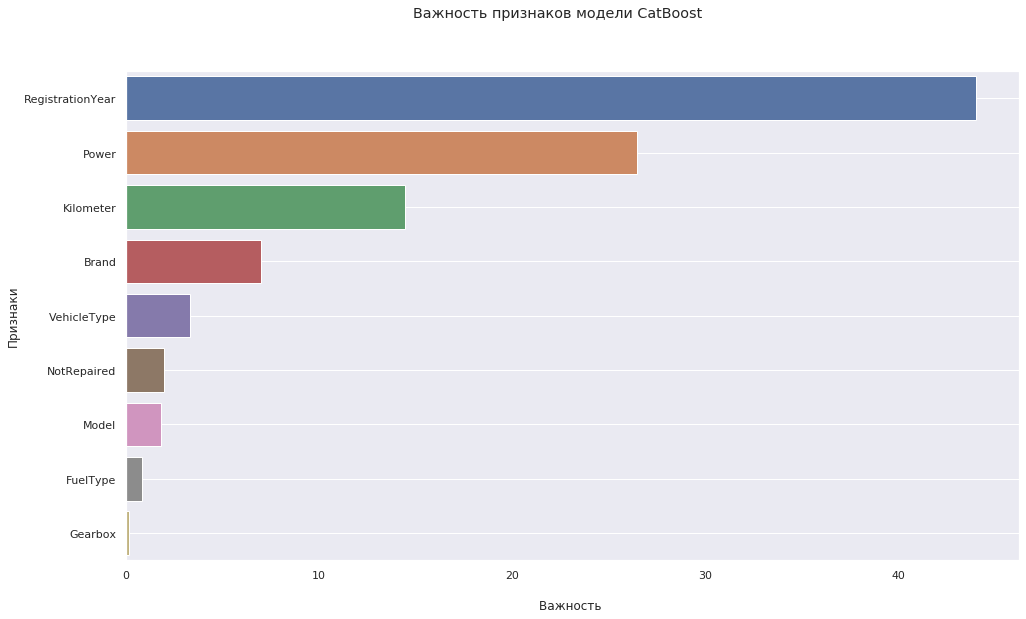

In [25]:
plt.figure(figsize=(16,9))
sns.barplot(x='Важность', y =  'Признаки',data = fi_cb)
plt.suptitle( 'Важность признаков модели CatBoost'+ "\n")
plt.ylabel('Признаки')
plt.xlabel("\n" + 'Важность ')
plt.grid()
plt.show()

По результатам значимости каждого признака для построения модли CatBoost предоставленным вышем, следует, что наиболее важным признаком является RegistrationYear, менее всего на мадель влияет признак Gearbox.

**Модель LightGBM**

In [26]:
features_train_ord_scale = pd.concat((pd.DataFrame(features_train_ord, columns=categorical_features),
                               pd.DataFrame(features_train_scal, columns=numerical_features)), axis=1)

In [27]:
lgbm_train_data = lightgbm.Dataset(features_train_ord_scale, label=target_train
                                   , categorical_feature=categorical_features, free_raw_data=False)
param = {'learning_rate': 1,
         'metric': 'rmse',
         'stratify': False,
         'seed': 42,
         'objective': 'regression',
         'verbosity': -1,
        }
booster_method = ['gbdt', 'gross']
max_depth = [2, 3, 4]

In [28]:
best_score = 10000
for boost in booster_method:
    params['boosting'] = boost
    for m_depth in max_depth:
        params['max_depth'] = m_depth
        score = lightgbm.cv(param, lgbm_train_data, nfold=3, categorical_feature=categorical_features)
        score = pd.DataFrame(score).iloc[-1]['rmse-mean']
        if score < best_score:
            best_score = score
            best_param = (boost, m_depth)

In [29]:
rmse_lgbm_train = best_score
print('Лучший RMSE:', rmse_lgbm_train)

Лучший RMSE: 1807.629161475201


In [30]:
%%time
param['max_depth'] = best_param[1]
param['boosting'] = best_param[0]
lgbm_model = lightgbm.train(param, lgbm_train_data, categorical_feature=categorical_features, num_boost_round=150)

CPU times: user 14.8 s, sys: 128 ms, total: 14.9 s
Wall time: 15 s


Важность признаков модели LightGBM

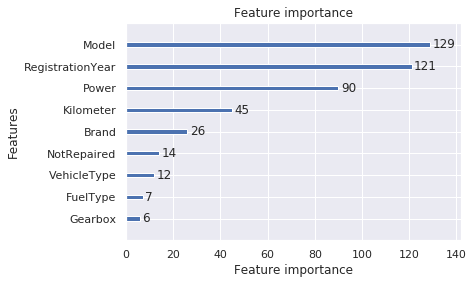

In [31]:
lightgbm.plot_importance(lgbm_model )

По графику значимости каждого признака для построения модли LightGBM предоставленным вышем, следует, что наиболее важным признаком является Model и RegistrationYear, менее всего на мадель влияют признаки Gearbox и FuelType.

**Вывод:**

Результаты обучения моделей приведены в таблице ниже:

In [32]:
d = ({'RMSE':[rmse_lr_train,rmse_cb_train,rmse_lgbm_train]
      ,'Время обучения (сек.)':['21','23.7','3.69']})
data = pd.DataFrame(data=d, index=['LinearRegression','CatBoost','LightGBM'])
data

,RMSE,Время обучения (сек.)
LinearRegression,2754.392176,21
CatBoost,1776.873178,23.7
LightGBM,1807.629161,3.69


Лучшей моделью по качеству можно назвать модель LinearRegression (RMSE: 2698.23, время обучения: 30 сек.), среди моделей градиентного бустинга наилучшей является LightGBM (RMSE: 1808.49, время обучения: 3.69 сек.).

## Анализ моделей

In [33]:
features_test_ord_scale = pd.concat((pd.DataFrame(features_test_ord, columns=categorical_features),
                               pd.DataFrame(features_test_scal, columns=numerical_features)), axis=1)
test_pool = Pool(data=features_test_ord_scale, cat_features=categorical_features)

In [34]:
%%time
predict = catboost_model.predict(test_pool)

CPU times: user 36.7 ms, sys: 0 ns, total: 36.7 ms
Wall time: 51.5 ms


In [35]:
rmse_cb_test = mse(target_test, predict)**0.5
print('RMSE тестовой выборки:{:.2f}'.format(rmse_cb_test))

RMSE тестовой выборки:7177.37


In [36]:
%%time
predict = lgbm_model.predict(features_test_ord_scale)

CPU times: user 347 ms, sys: 0 ns, total: 347 ms
Wall time: 290 ms


In [37]:
rmse_lgbm_test = mse(target_test, predict)**0.5
print('RMSE тестовой выборки:{:.2f}'.format(rmse_lgbm_test))

RMSE тестовой выборки:1772.34


**Вывод:**

Результаты предсказаний моделей приведены в таблице ниже:

In [38]:
d = ({'RMSE':[rmse_lr_test, rmse_cb_test, rmse_lgbm_test]
      ,'Время предсказания (сек.)':['0.010','0.008','0.281']})
data = pd.DataFrame(data=d, index=['LinearRegression','CatBoost','LightGBM'])
data

,RMSE,Время предсказания (сек.)
LinearRegression,2749.010792,0.010
CatBoost,7177.371241,0.008
LightGBM,1772.341909,0.281


Модель LinearRegression также показывает лучшее качество (RMSE: 2698.23, время предсказания: 101 мс.). Качество моделей градиентного бустинга примерно одинаковое. Наилучшей по времени наилучшей является CatBoost (RMSE: 1743.65, время обучения: 8 мс.).

## Общий вывод

В ходе выполнения проекта о определении стоимости автомобилей были выполнены следующие шаги:

1) Загружены и подготовлены данные

Произведена оптимизация типов данных, удалены дубликаты, заполнены пропуски данных, удалены лишние столбцы, а также выявлены и удалены выбросы значений в столбцах.

2) Обучены модели LinearRegression, CatBoost, LightGBM

Лучшей моделью по качеству можно назвать модель LinearRegression (RMSE: 2698.23, время обучения: 30 сек.), среди моделей градиентного бустинга наилучшей является LightGBM (RMSE: 1808.49, время обучения: 3.69 сек.).

3) Проанализированы модели

Модель LinearRegression также показывает лушее качество (RMSE: 2698.23, время предсказания: 101 мс.). Качество моделей градиентного бустинга примерно одинаковое, наилучшей по времени наилучшей является CatBoost (RMSE: 1743.65, время обучения: 8 мс.), что во много раз опережает время предсказания модели LightGBM (RMSE: 1775.01, время обучения: 281 мс.).

Исходя из итогов приведенных выше, следует, что лучшей моделью градиентного бустинга можно считать модель CatBoost.